In [1]:
%load_ext autoreload

In [2]:
"Results for MDM algorithm in table 6. generation of image in figure 6"

'Results for MDM algorithm in table 6. generation of image in figure 6'

In [3]:
import numpy as np
import pickle

from basicOperations.manifoldOperations import matrixDistance, frechetMean, tangentMap

In [4]:
numberSubjects = 91
numberChannels = 12
numberGestures = 10
trialsPerGesture = 36

In [5]:
collateData = []

for subjectNumber in range(1, 100):
    if subjectNumber not in [5, 11, 14, 17, 18, 35, 38, 41]:
        name = "../formattedData/" + str(subjectNumber) + ".pkl"
        with open(name, "rb") as file:
            loadedData = pickle.load(file)

        Features = loadedData["EMG"]
        mean = np.mean(Features, axis = -1)
        std = np.std(Features, axis = -1)
        normalizedFeatures = (Features - mean[..., np.newaxis])/std[..., np.newaxis]
        Labels = loadedData["Labels"]
        samples = 2 * loadedData["Frequency"]

        Indices =  {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}
        for i in range(len(Labels)):
            Indices[Labels[i]].append(i)

        gesturesLabels = np.zeros((numberGestures, trialsPerGesture, numberChannels, numberChannels))
        for i in range(numberGestures):
            for j in range(trialsPerGesture):
                gesturesLabels[i, j] = (1/samples) * normalizedFeatures[Indices[i][j], :, :] @ normalizedFeatures[Indices[i][j], :, :].T
        
        collateData.append(gesturesLabels)

In [6]:
collateData = np.array(collateData)
print(collateData.shape)

(91, 10, 36, 12, 12)


In [7]:
geodesicDistance = matrixDistance()
manifoldMean = frechetMean()
logMap = tangentMap()

In [8]:
"""First 18 repeats of each gesture for training and last 18 for testing. 50 - 50 split."""

'First 18 repeats of each gesture for training and last 18 for testing. 50 - 50 split.'

In [9]:
trainCentroid = np.zeros((numberSubjects, numberGestures, numberChannels, numberChannels))

for subject in range(numberSubjects):
    for i in range(numberGestures):
        trainCentroid[subject, i, :, :] = manifoldMean.mean(collateData[subject, i, :18, :, :])

testFeatures = np.zeros((numberSubjects, 180, numberChannels, numberChannels))
testLabels = np.zeros((numberSubjects, 180))

for subject in range(numberSubjects):
    count = 0
    for i in range(numberGestures):
        testFeatures[subject, count:count + 18] = collateData[subject, i, 18:, :, :]
        testLabels[subject, count:count + 18] = [i] * 18
        count += 18

predictLabels = np.zeros((numberSubjects, 180))

for subject in range(numberSubjects):
    for k in range(180):
        distances = np.zeros((numberGestures))
        for m in range(numberGestures):
            distances[m] = geodesicDistance.distance(testFeatures[subject, k], trainCentroid[subject, m])
        predictLabels[subject, k] = np.argmin(distances)

correctsSplitA = np.zeros((numberSubjects))

for subject in range(numberSubjects):
    correct = np.mean((predictLabels[subject] == testLabels[subject]))
    correctsSplitA[subject] = correct

In [10]:
"""First 27 repeats of each gesture for training and last 9 for testing. 75 - 25 split."""

'First 27 repeats of each gesture for training and last 9 for testing. 75 - 25 split.'

In [11]:
trainCentroid = np.zeros((numberSubjects, numberGestures, numberChannels, numberChannels))

for subject in range(numberSubjects):
    for i in range(numberGestures):
        trainCentroid[subject, i, :, :] = manifoldMean.mean(collateData[subject, i, :27, :, :])

testFeatures = np.zeros((numberSubjects, 90, numberChannels, numberChannels))
testLabels = np.zeros((numberSubjects, 90))

for subject in range(numberSubjects):
    count = 0
    for i in range(numberGestures):
        testFeatures[subject, count:count + 9] = collateData[subject, i, 27:, :, :]
        testLabels[subject, count:count + 9] = [i] * 9
        count += 9

predictLabels = np.zeros((numberSubjects, 90))

for subject in range(numberSubjects):
    for k in range(90):
        distances = np.zeros((numberGestures))
        for m in range(numberGestures):
            distances[m] = geodesicDistance.distance(testFeatures[subject, k], trainCentroid[subject, m])
        predictLabels[subject, k] = np.argmin(distances)

correctsSplitB = np.zeros((numberSubjects))

for subject in range(numberSubjects):
    correct = np.mean((predictLabels[subject] == testLabels[subject]))
    correctsSplitB[subject] = correct

In [12]:
"""for i in range(numberSubjects):
    print("{:.3f}".format(correctsSplitA[i]))
print("{:.3f}".format(np.mean(correctsSplitA)))"""

'for i in range(numberSubjects):\n    print("{:.3f}".format(correctsSplitA[i]))\nprint("{:.3f}".format(np.mean(correctsSplitA)))'

In [13]:
"""for i in range(numberSubjects):
    print("{:.3f}".format(correctsSplitB[i]))
print("{:.3f}".format(np.mean(correctsSplitB)))"""

'for i in range(numberSubjects):\n    print("{:.3f}".format(correctsSplitB[i]))\nprint("{:.3f}".format(np.mean(correctsSplitB)))'

In [22]:
print(np.mean(correctsSplitA))
print(np.mean(correctsSplitB))

0.7685592185592185
0.7978021978021976


In [14]:
meanValue = np.zeros((numberSubjects, numberChannels, numberChannels))
for i in range(numberSubjects):
    meanValue[i] = manifoldMean.mean(collateData[i].reshape(-1, numberChannels, numberChannels))

logMapped = np.zeros((numberSubjects, numberGestures, trialsPerGesture, numberChannels, numberChannels))
for subject in range(numberSubjects):
    for gesture in range(numberGestures):
        for repeat in range(trialsPerGesture):
            logMapped[subject, gesture, repeat] = logMap.logMap(collateData[subject, gesture, repeat], meanValue[subject])

In [15]:
def vectorizeMatrix(matrix):

    mask = np.tril(np.ones((numberChannels, numberChannels), dtype = bool))
    lowerTriangularParts = matrix[mask]

    return lowerTriangularParts

In [16]:
VEC = np.zeros((numberSubjects, numberGestures, trialsPerGesture, 78))
for subject in range(numberSubjects):
    for gesture in range(numberGestures):
        for repeat in range(trialsPerGesture):
            VEC[subject, gesture, repeat] = vectorizeMatrix(logMapped[subject, gesture, repeat])

In [17]:
trainMappedCentroid = np.zeros((numberSubjects, numberGestures, 78))

for subject in range(numberSubjects):
    for i in range(numberGestures):
        trainMappedCentroid[subject, i, :] = np.mean(VEC[subject, i, :18, :], axis = 0)

testMappedFeatures = np.zeros((numberSubjects, 180, 78))
testMappedLabels = np.zeros((numberSubjects, 180))

for subject in range(numberSubjects):
    count = 0
    for i in range(numberGestures):
        testMappedFeatures[subject, count:count + 18] = VEC[subject, i, 18:, :]
        testMappedLabels[subject, count:count + 18] = [i] * 18
        count += 18

predictMappedLabels = np.zeros((numberSubjects, 180))

for subject in range(numberSubjects):
    for k in range(180):
        distances = np.zeros((numberGestures))
        for m in range(numberGestures):
            distances[m] = np.linalg.norm(testMappedFeatures[subject, k] - trainMappedCentroid[subject, m])
        predictMappedLabels[subject, k] = np.argmin(distances)

correctsMapped = np.zeros((numberSubjects))

for subject in range(numberSubjects):
    correct = np.mean((predictMappedLabels[subject] == testMappedLabels[subject]))
    correctsMapped[subject] = correct

In [18]:
print(np.mean(correctsMapped))

0.77008547008547


In [19]:
from matplotlib import font_manager
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

fontPath = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman_Italic.ttf'
fontProp = font_manager.FontProperties(fname = fontPath)

font_manager.fontManager.addfont(fontPath)
mpl.rcParams['font.family'] = fontProp.get_name()

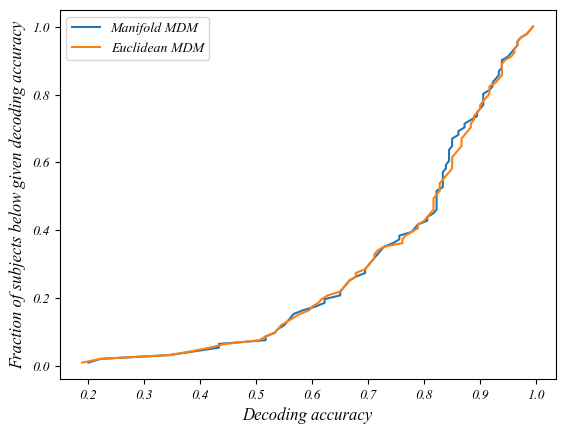

In [20]:
colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#00FFFF', '#FF00FF', '#FFA500', '#800080', '#A52A2A', '#FFC0CB']

colors = ListedColormap(colors)

plt.plot(np.sort(correctsSplitA), np.arange(1,  92)/91, label = "Manifold MDM")
plt.plot(np.sort(correctsMapped), np.arange(1,  92)/91, label = "Euclidean MDM")

plt.xlabel('Decoding accuracy', fontproperties = fontProp, fontsize = 12)
plt.ylabel('Fraction of subjects below given decoding accuracy', fontproperties = fontProp, fontsize = 12)
plt.legend(loc = 'upper left')
"""plt.savefig("MDMdecodingAccuracy.eps", format = "eps")"""
plt.show()
plt.close()

In [21]:
%autoreload